## Webscraping Data on Arbeitstellen from the website of the BA

This code automatically downloads all excel files (2020-2025) and all pdf files (pre 2020) from the BA's website, extracts the relevant tables from the files and merges them together in one usable data frame. 

The first step is to load the relevant packages. 

In [ ]:
!pip install selenium pandas openpyxl requests os

1. Step: Automized download of all excel files (February 2020 - February 2025) from the BA website (https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=analyse-gemeldete-arbeitsstellen-kldb2010)

In the code I first browse through all pages of the website and search for links that end with 'xls' or 'xlxs' indicating excel files and then I store all links. Then, I execute those links and download all excel files and save them in the same folder. 

In [ ]:
# === Load Packages ===

from selenium import webdriver # Selenium is used for the automatic download of files from the web browser
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import os
import requests
import urllib.parse
import time

# === Setup Edge ===

# The microsoft edge driver is required for selenium to work. This code opens the microsoft edge driver:
service = Service("C:\\Users\\jhummels\\OneDrive - DIW Berlin\\Gehlen, Annica's files - retirement-labor-shortages\\edgedriver\\msedgedriver.exe")
options = webdriver.EdgeOptions()
options.add_argument("start-maximized")
driver = webdriver.Edge(service=service, options=options)

# === Opening Ergebnisseite ===

# This command opens the BA's website from which we want to download all the excel sheets 
driver.get("https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=analyse-gemeldete-arbeitsstellen-kldb2010")
wait = WebDriverWait(driver, 20)

# === Accepting Cookie-Banner ===

# If we don't deal with the cookies window that automatically opens when opening the website link, our webscraping will not work. The following code adresses 
# this problem. However, the command still has issues with accepting cookies by itself, so when the cookie window opens you have to manually accept cookies and then the code will run errorless. Except for 
# accepting cookies, you shoule not do anything in the window while the code is running. Once the command is executed, the window should close automatically. 
try:
    cookie_button = wait.until(EC.element_to_be_clickable((By.ID, "cc-all")))
    cookie_button.click()
    print("✅ Cookies akzeptiert.")
    time.sleep(2)
except:
    print("ℹ️ Kein Cookie-Banner gefunden oder schon geschlossen.") # This is the response you will get if you accept cookies manually, which you have to do. 

# === Navigation through all subpages and collection of all Excel-Links ===

# The following code browses through all subpages on the website and obtains all links, which initiate the download of excel files

all_excel_links = []
page_number = 1

while True:
    print(f"\n🔄 Lade Seite {page_number}...")

    try:
        wait.until(EC.presence_of_all_elements_located((By.XPATH, "//a[contains(@href, '.xls')] | //a[contains(@href, '.xlsx')]")))
    except:
        print("❌ Keine Excel-Links gefunden auf dieser Seite.")
        break

    elements = driver.find_elements(By.XPATH, "//a[contains(@href, '.xls')] | //a[contains(@href, '.xlsx')]")
    for el in elements:
        href = el.get_attribute("href")
        if href and href not in all_excel_links:
            all_excel_links.append(href)

    # Searching for next subtab and press 'next'
    try:
        next_link = driver.find_element(By.XPATH, "//a[contains(@class, 'forward') and contains(@class, 'button')]")
        ActionChains(driver).move_to_element(next_link).perform()
        next_link.click()
        time.sleep(2)
        page_number += 1
    except:
        print("✅ Keine weitere Seite gefunden oder Button deaktiviert.")
        break

driver.quit()

# === Printing all Excel-Links ===
print(f"\n🔗 Insgesamt {len(all_excel_links)} Excel-Dateien gefunden.")

# === Preparing Download-Folder ===
os.makedirs(r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~1", exist_ok=True)
failed_links = []

# === Hilfsfunktion: Retry-Logik ===
def download_with_retries(url, retries=3, delay=5):
    headers = {"User-Agent": "Mozilla/5.0"}
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=20)
            if response.status_code == 200:
                return response
        except Exception as e:
            print(f"⚠️ Versuch {i+1} fehlgeschlagen für {url}: {e}")
            time.sleep(delay)
    return None

# === Download Excel-Files ===
for link in all_excel_links:
    filename = link.split("/")[-1].split("?")[0].split(";")[0]
    filename = urllib.parse.unquote(filename)
    filepath = os.path.join(r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~1", filename)

    # Falls Datei schon existiert, überspringen
    if os.path.exists(filepath):
        print(f"⏩ Überspringe bereits vorhandene Datei: {filename}")
        continue

    print(f"⬇️ Lade herunter: {filename}")
    response = download_with_retries(link)
    if response:
        try:
            with open(filepath, "wb") as f:
                f.write(response.content)
            print(f"✅ Erfolgreich gespeichert: {filename}")
        except Exception as e:
            print(f"❌ Fehler beim Speichern von {filename}: {e}")
            failed_links.append(link)
    else:
        print(f"❌ Endgültig fehlgeschlagen: {filename}")
        failed_links.append(link)

# === Safe all failed links ===
if failed_links:
    with open("failed_excels.txt", "w", encoding="utf-8") as f:
        for link in failed_links:
            f.write(link + "\n")
    print(f"\n⚠️ {len(failed_links)} Dateien konnten nicht geladen werden. Gespeichert in 'failed_excels.txt'")
else:
    print("\n🎉 Alle Excel-Dateien erfolgreich heruntergeladen!")


2. Step: Automized download of all pdf files (October 2011 - February 2020) from the BA website (https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=analyse-gemeldete-arbeitsstellen-kldb2010)

I use the same procedure as for the download of Excel file just that here I am looking for links ending with 'pdf'. 

In [ ]:
# === Load Packages ===

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import os
import requests
import urllib.parse
import time

# === Edge Setup ===
service = Service("C:\\Users\\jhummels\\OneDrive - DIW Berlin\\Gehlen, Annica's files - retirement-labor-shortages\\edgedriver\\msedgedriver.exe")
options = webdriver.EdgeOptions()
options.add_argument("start-maximized")
driver = webdriver.Edge(service=service, options=options)

# === Ergebnisseite öffnen ===
driver.get("https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=analyse-gemeldete-arbeitsstellen-kldb2010")
wait = WebDriverWait(driver, 20)


# === Cookies akzeptieren ===
try:
    cookie_button = wait.until(EC.element_to_be_clickable((By.ID, "cc-all")))
    cookie_button.click()
    print("✅ Cookies akzeptiert.")
    time.sleep(2)
except:
    print("ℹ️ Kein Cookie-Banner gefunden oder schon geschlossen.")

# === Sammeln aller PDF-Links von allen Seiten ===
all_pdf_links = []
page_number = 1

while True:
    print(f"\n🔄 Lade Seite {page_number}...")

    try:
        wait.until(EC.presence_of_all_elements_located((By.XPATH, "//a[contains(@href, '.pdf')]")))
    except:
        print("❌ Keine PDF-Links gefunden auf dieser Seite.")
        break

    elements = driver.find_elements(By.XPATH, "//a[contains(@href, '.pdf')]")
    for el in elements:
        href = el.get_attribute("href")
        if href and href not in all_pdf_links:
            all_pdf_links.append(href)

    # Weiterblättern
    try:
        next_link = driver.find_element(By.XPATH, "//a[contains(@class, 'forward') and contains(@class, 'button')]")
        ActionChains(driver).move_to_element(next_link).perform()
        next_link.click()
        time.sleep(2)
        page_number += 1
    except:
        print("✅ Keine weitere Seite gefunden oder Button deaktiviert.")
        break

driver.quit()

# === Ordner vorbereiten ===
os.makedirs(r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~2", exist_ok=True)
failed_links = []

# === Hilfsfunktion: Retry-Logik ===
def download_with_retries(url, retries=3, delay=5):
    headers = {"User-Agent": "Mozilla/5.0"}
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=20)
            if response.status_code == 200:
                return response
        except Exception as e:
            print(f"⚠️ Versuch {i+1} fehlgeschlagen für {url}: {e}")
            time.sleep(delay)
    return None

# === PDFs herunterladen ===
for link in all_pdf_links:
    filename = link.split("/")[-1].split("?")[0].split(";")[0]
    filename = urllib.parse.unquote(filename)
    filepath = os.path.join(r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~2", filename)

    # Falls Datei schon existiert, überspringen
    if os.path.exists(filepath):
        print(f"⏩ Überspringe bereits vorhandene Datei: {filename}")
        continue

    print(f"⬇️ Lade herunter: {filename}")
    response = download_with_retries(link)
    if response:
        try:
            with open(filepath, "wb") as f:
                f.write(response.content)
            print(f"✅ Erfolgreich gespeichert: {filename}")
        except Exception as e:
            print(f"❌ Fehler beim Speichern von {filename}: {e}")
            failed_links.append(link)
    else:
        print(f"❌ Endgültig fehlgeschlagen: {filename}")
        failed_links.append(link)

# === Fehlgeschlagene Links speichern ===
if failed_links:
    with open("failed_pdfs.txt", "w", encoding="utf-8") as f:
        for link in failed_links:
            f.write(link + "\n")
    print(f"\n⚠️ {len(failed_links)} Dateien konnten nicht geladen werden. Gespeichert in 'failed_pdfs.txt'")
else:
    print("\n🎉 Alle PDFs erfolgreich heruntergeladen!")


3. Step: Read all PDF files and extract relevant tables with the Engpass Indicators, then convert the data into a machine readable format (csv, xlsx)

I browse through all pdf files and use the Fitz algorithm from the PyMuPDF to extract the desired table using key words and patterns that detect the right table in the pdf file. In the webscraping for the labor tightness data, I use the camelot package, which is a little bit more advanced when used with the 'network' algorithm. 

In [ ]:
import os
import re
import fitz  # PyMuPDF
import pandas as pd

# Input and output folders
input_folder = r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~2"
output_folder = r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~3"
os.makedirs(output_folder, exist_ok=True)

# Table detection pattern
pattern = re.compile(
    r"(?P<BKZ>\d{3})\s+(?P<Beruf>[\wäöüÄÖÜß\-,.()\/&\s]+?)\s+"
    r"(?P<Zugang>[\d.]+)\s+(?P<Zugang_V>[-+.,\d]+)\s+"
    r"(?P<Bestand>[\d.]+)\s+(?P<Bestand_V>[-+.,\d]+)\s+"
    r"(?P<Anteil>[\d.,]+)\s+(?P<Anteil_V>[-+.,\d]+)\s+"
    r"(?P<Vakanzzeit>[\d.,]+)\s+(?P<Vakanzzeit_V>[-+.,\d]+)\s+"
    r"(?P<Arbeitslose>[\d.]+)\s+(?P<Arbeitslose_V>[-+.,\d]+)\s+"
    r"(?P<Relation>[\d.,]+)\s+(?P<Relation_V>[-+.,\d]+)"
)

# Loop through all PDFs
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".pdf"):
        pdf_path = os.path.join(input_folder, filename)
        doc = fitz.open(pdf_path)

        # Extract text from pages likely to contain the table
        text = ""
        for i, page in enumerate(doc):
            page_text = page.get_text()
            # Look for BKZ + numeric pattern
            if re.search(r"\b\d{3}\s+[A-Za-zÄÖÜäöüß]", page_text) and re.search(r"\d+\s+[-+,.0-9]+\s+\d+", page_text):
                text += page_text + "\n"

        # Match rows using regex
        rows = []
        for match in pattern.finditer(text):
            row = match.groupdict()
            for key in row:
                row[key] = row[key].replace(".", "").replace(",", ".") if key != "Beruf" else row[key].strip()
            rows.append(row)

        if rows:
            df = pd.DataFrame(rows)
            for col in df.columns:
                if col != "Beruf":
                    df[col] = pd.to_numeric(df[col], errors="coerce")

            # Save CSV
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + ".csv")
            df.to_csv(output_path, index=False, encoding="utf-8-sig")
            print(f"✓ Saved: {output_path}")
        else:
            print(f"⚠️ No table found in: {filename}")


4. Merge all tables extracted from pdfs into one data frame and add a year and bundesland column based on their file name


In [ ]:
# Load packages
from pathlib import Path
import os
import pandas as pd
import re

# Folder with individual CSVs
csv_folder = r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~3"

# List to collect all dataframes
all_dfs = []

# Regex to extract Bundesland and date info
filename_pattern = re.compile(r"kldb2010-(\d{2})-0-(\d{6})")

for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        match = filename_pattern.search(file)
        if match:
            bundesland = match.group(1)
            year = match.group(2)[:4]
            month = match.group(2)[4:]
        else:
            print(f"⚠️ Skipping file with unexpected name: {file}")
            continue

        # Load CSV and add metadata
        file_path = os.path.join(csv_folder, file)
        df = pd.read_csv(file_path)
        df["Bundesland"] = bundesland
        df["Year"] = int(year)
        df["Month"] = int(month)
        all_dfs.append(df)

# Merge all
combined_df = pd.concat(all_dfs, ignore_index=True)

# Export
output_csv = os.path.join(csv_folder, "combined_arbeitsagentur_data.csv")
output_excel = os.path.join(csv_folder, "combined_arbeitsagentur_data.xlsx")

combined_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
combined_df.to_excel(output_excel, index=False)

print(f"✓ Combined CSV saved to: {output_csv}")
print(f"✓ Combined Excel saved to: {output_excel}")


5. Clean PDF data frame and get rid of little inaccuracies. Extract BKZ and add as new columns. Delete rows that don't hold any information and rename columns such that the names fit the names of the excel tables


In [ ]:
# Import relevant libraries: 

import pandas as pd
import re  # <-- Add this

data = combined_df.copy()

# Show all rows
pd.set_option('display.max_rows', 2000)

# Optional: also widen column display if needed
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Keep only rows where BKZ is a proper 3-digit number between 100 and 999
data = data[data["BKZ"].astype(str).str.fullmatch(r"\d{3}")]

import re

def extract_clean_bkz_and_beruf(row):
    beruf_raw = str(row.get("Beruf", "")).replace("\n", " ").strip()

    # Match pattern like: "814 Human- und Zahnmedizin" (ignore any garbage before it)
    match = re.search(r"(\d{3})\s+([A-ZÄÖÜa-zäöüß].+)", beruf_raw)
    if match:
        row["BKZ"] = match.group(1)
        row["Beruf"] = match.group(2).strip()
    return row

data = data.apply(extract_clean_bkz_and_beruf, axis=1)
# Keep rows where Beruf starts with a letter (i.e., likely a real label)
data = data[
    data["Beruf"].notna() &
    data["Beruf"].astype(str).str.match(r"^[A-ZÄÖÜa-zäöüß]")
]

# Clean up whitespace and hidden characters in all string columns
for col in ["BKZ", "Beruf", "Bundesland"]:
    data[col] = data[col].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
data = data.drop_duplicates(subset=["BKZ", "Beruf", "Bundesland", "Year", "Month"], keep="first")

# Rename columns of PDF data to match column names of the Excel Data 

data = data.rename(columns={
    "Anteil": "3_Monate_Vakant_Anteil",
    "Anteil_V" : "3_Monate_Vakant_V_abs",
    "Vakanzzeit" : "abgesch_Vakanzzeit_Tage",
    "Vakanzzeit_V" : "abgesch_Vakanzzeit_V_abs"
})

data.head()

7. Extract the right tables from all excel files, then clean and improve format of excel data frame, then merge all excel tables into one data frame.

I extract the right tables from the excel files by defining the sheet names that include the relevant table.


In [ ]:
# Load relevant libraries

import os
import pandas as pd
import re

# Path to folder with Excel files
excel_folder = r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\ARBEIT~1"

# Collect cleaned DataFrames
all_dfs = []

# Loop through Excel files
for file in os.listdir(excel_folder):
    if file.endswith(".xlsx"):
        filepath = os.path.join(excel_folder, file)
        try:
            # Load the sheet (header on row 7)
            df = pd.read_excel(filepath, sheet_name="3.1 Engpass_Tab1", header=7)

            # Drop last 4 columns
            df = df.iloc[:, :-4]

            # Rename columns (up to 24)
            df.columns = [
             "Drop", "Beruf",
             "Zugang", "Zugang_V",
             "Bestand", "Bestand_V",
             "3_Monate_Vakant_abs", "3_Monate_Vakant_V",
             "3_Monate_Vakant_Anteil", "3_Monate_Vakant_V_abs",
             "abgesch_Vakanzzeit_Tage", "abgesch_Vakanzzeit_V_abs",
             "Arbeitslose", "Arbeitslose_V",
             "SGBIII_abs", "SGBIII_V",
             "SGBII_abs", "SGBII_V",
             "Relation", "Relation_V",
             "SGBIII_abs_2", "SGBIII_V_2",
             "SGBII_abs_2", "SGBII_V_2"
            ]

            # Drop the first column (empty)
            df = df.drop(columns="Drop")

            # Remove footer or malformed rows
            df = df[df["Beruf"].astype(str).str.match(r"^\d{3}\s+.+")]

            # Split BKZ from Beruf
            df[["BKZ", "Beruf"]] = df["Beruf"].str.extract(r"^(\d{3})\s+(.+)$")

            # Convert numeric columns
            numeric_cols = [col for col in df.columns if col not in ["Beruf", "BKZ"] and df[col].ndim == 1]
            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Drop "Insgesamt" row if present
            df = df[~df.iloc[:, 1].astype(str).str.contains("Insgesamt", na=False)]

            # Add metadata from filename
            match = re.search(r"kldb2010-(\d{2})-0-(\d{6})", file)
            if match:
                df["Bundesland"] = match.group(1)
                df["Year"] = int(match.group(2)[:4])
                df["Month"] = int(match.group(2)[4:])
            else:
                df["Bundesland"] = df["Year"] = df["Month"] = None

            df["source_file"] = file

            all_dfs.append(df)

        except Exception as e:
            print(f"❌ Error processing {file}: {e}")

# Combine all cleaned data
combined_excel_df = pd.concat(all_dfs, ignore_index=True)

# Preview
print(f"✓ Combined {len(all_dfs)} files. Total rows: {combined_excel_df.shape[0]}")
combined_excel_df.head()


Preview of the excel data frame

In [ ]:
combined_excel_df.head()

Inquiry of NA count for the webscraped PDF and Excel Data Frame

In [ ]:
print(data.isna().sum())
print(combined_excel_df.isna().sum())

SGBIII_abs, SGBIII_V, SGBII_abs, SGBII_V all have 59452 missing values (which are all rows), so we can drop them without any bad conscience 

In [ ]:
combined_excel_df = combined_excel_df.drop(columns=[
    "SGBIII_abs", "SGBIII_V", "SGBII_abs", "SGBII_V"
])

Merging PDF and Excel data frames into one data frame

In [ ]:

# Reindex `data` to match the column structure of `combined_excel_df`
data_aligned = data.reindex(columns=combined_excel_df.columns)

# Append older `data` before `combined_excel_df`
full_df = pd.concat([data_aligned, combined_excel_df], ignore_index=True)

# Preview result
print(full_df.shape)
full_df.head()


Improve column names and order


In [ ]:
# Adjust column names in a better order


desired_order = [
    'Bundesland', 'Year', 'Month',
    'BKZ', 'Beruf',
    'Zugang', 'Zugang_V',
    'Bestand', 'Bestand_V',
    '3_Monate_Vakant_abs', '3_Monate_Vakant_V',
    '3_Monate_Vakant_Anteil', '3_Monate_Vakant_V_abs',
    'abgesch_Vakanzzeit_Tage', 'abgesch_Vakanzzeit_V_abs',
    'Arbeitslose', 'Arbeitslose_V',
    'Relation', 'Relation_V',
    'SGBIII_abs_2', 'SGBIII_V_2',
    'SGBII_abs_2', 'SGBII_V_2',
    'source_file'
]

# Keep only the columns that are actually in the DataFrame
existing_columns = [col for col in desired_order if col in full_df.columns]

# Reorder
full_df = full_df[existing_columns]


full_df.head()



Export the full data frame of all webscraped data for Arbeitsstellen nach Berufsgruppen into an excel file

In [ ]:
full_df.to_csv(r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\Merged_data.csv", index=False)

## In the next section I further clean the data: 

I copy the data to clean it. 

In [4]:
df = full_df.copy()

At first, I clean the Beruf strings, so they don't include any special characters. 

In [5]:
# Step 1: Clean Beruf strings

df['Beruf'] = (
    df['Beruf']
    .str.lower()
    .str.replace('-', ' ', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)


Inquiry of missing time periods

In [6]:
import pandas as pd
import itertools

years = df['Year'].unique()
months = df['Month'].unique()
bundeslaender = df['Bundesland'].unique()


#  Create a full grid of all expected combinations
full_grid = pd.DataFrame(
    list(itertools.product(years, months, bundeslaender)),
    columns=['Year', 'Month', 'Bundesland']
)

actual = df[['Year', 'Month', 'Bundesland']].drop_duplicates()

merged = full_grid.merge(actual, on=['Year', 'Month', 'Bundesland'], how='left', indicator=True)
missing_combinations = merged[merged['_merge'] == 'left_only']


print("Missing combinations:", len(missing_combinations))
missing_combinations[['Year', 'Month', 'Bundesland']].head(330)



Missing combinations: 320


,Year,Month,Bundesland
48,2011,1,1
49,2011,1,2
50,2011,1,3
51,2011,1,4
52,2011,1,5
...,...,...,...
2875,2025,9,12
2876,2025,9,13
2877,2025,9,14
2878,2025,9,15


Add date column and add missing rows because the imported data doesn't have continues values for all
Berufe in each year/month/bundesland and hence we add those rows but put NA's so we can understand for 
which Berufe we have missing values in certain time periods



In [7]:
# Create date column
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# === Step 2: Identify unique values for the full grid
all_dates = pd.date_range(start='2011-10-01', end='2025-02-01', freq='MS')
all_bundeslaender = df['Bundesland'].dropna().unique()
all_bkz = df['BKZ'].dropna().unique()

full_index = pd.MultiIndex.from_product(
    [all_dates, all_bundeslaender, all_bkz],
    names=['date', 'Bundesland', 'BKZ']
)

# === Step 3: Build cleaned dataset
id_vars = ['date', 'Bundesland', 'BKZ']
value_vars = [col for col in df.columns if col not in id_vars + ['Year', 'Month', 'source_file']]

# Drop duplicates before setting index
df_grouped = df[id_vars + value_vars].drop_duplicates(subset=id_vars)

# Now aggregate (if needed) and ensure unique index
df_grouped = df_grouped.groupby(id_vars, as_index=False).first()

# === Step 4: Reindex to complete grid
df_grouped = df_grouped.set_index(id_vars)
df_complete = df_grouped.reindex(full_index).reset_index()

# === Step 5: Restore year/month
df_complete['Year'] = df_complete['date'].dt.year
df_complete['Month'] = df_complete['date'].dt.month

# === Step 6: Map back Beruf (from BKZ)
bkz_to_beruf = df[['BKZ', 'Beruf']].drop_duplicates().dropna().set_index('BKZ')['Beruf']
df_complete['Beruf'] = df_complete['BKZ'].map(bkz_to_beruf)

df_complete = df_complete.set_index('date')

df_complete.head()


,Bundesland,BKZ,Beruf,Zugang,Zugang_V,Bestand,Bestand_V,3_Monate_Vakant_abs,3_Monate_Vakant_V,3_Monate_Vakant_Anteil,...,Arbeitslose,Arbeitslose_V,Relation,Relation_V,SGBIII_abs_2,SGBIII_V_2,SGBII_abs_2,SGBII_V_2,Year,Month
date,,,,,,,,,,,,,,,,,,,,,
2011-10-01,1,814,human und zahnmedizin,147.0,10.5,66.0,-1.4,NaN,NaN,48.3,...,93.0,-9.4,140.0,-12.0,NaN,NaN,NaN,NaN,2011,10
2011-10-01,1,921,werbung und marketing,1949.0,4.2,595.0,17.4,NaN,NaN,46.5,...,783.0,-1.0,132.0,-24.0,NaN,NaN,NaN,NaN,2011,10
2011-10-01,1,821,altenpflege,1644.0,-13.5,561.0,-3.6,NaN,NaN,50.6,...,748.0,-25.4,133.0,-39.0,NaN,NaN,NaN,NaN,2011,10
2011-10-01,1,721,versicherungs u. finanzdienstleistungen,437.0,6.8,136.0,-5.6,NaN,NaN,42.8,...,500.0,-10.6,368.0,-20.0,NaN,NaN,NaN,NaN,2011,10
2011-10-01,1,813,"gesundh.,krankenpfl.,rettungsd.geburtsh.",1563.0,24.9,453.0,17.9,NaN,NaN,38.8,...,708.0,-6.2,156.0,-40.0,NaN,NaN,NaN,NaN,2011,10


Reorder columns

In [8]:
desired_order = [
    'date', 'Bundesland', 'Year', 'Month',
    'BKZ', 'Beruf',
    'Zugang', 'Zugang_V',
    'Bestand', 'Bestand_V',
    '3_Monate_Vakant_abs', '3_Monate_Vakant_V',
    '3_Monate_Vakant_Anteil', '3_Monate_Vakant_V_abs',
    'abgesch_Vakanzzeit_Tage', 'abgesch_Vakanzzeit_V_abs',
    'Arbeitslose', 'Arbeitslose_V',
    'Relation', 'Relation_V',
    'SGBIII_abs_2', 'SGBIII_V_2',
    'SGBII_abs_2', 'SGBII_V_2',
    'source_file'
]

# Keep only the columns that are actually in the DataFrame
existing_columns = [col for col in desired_order if col in df_complete.columns]

# Reorder
df_complete = df_complete[existing_columns]

Check if missingness of variables correlates with each other

In [9]:
missing_corr = df_complete[['Zugang', 'Bestand']].isnull().astype(int).corr().iloc[0, 1]

print(f"Correlation of missingness between 'var1' and 'var2': {missing_corr:.2f}")

Correlation of missingness between 'var1' and 'var2': 1.00


Plot Berufsgruppen sorted by highest missingness in the variable Zugang. 

In [ ]:
missing_zugang = (
    df_complete.groupby('Beruf')['Zugang']
    .apply(lambda x: x.isnull().sum())
    .sort_values(ascending=False)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
missing_zugang.plot(kind='barh')

plt.title('Number of Missing "Zugang" Values by Beruf')
plt.xlabel('Count of Missing Values')
plt.ylabel('Beruf')
plt.gca().invert_yaxis()  # Optional: highest values on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Drop top 50 Berufe with the highest missing rate for Zugang

In [ ]:
# Step 1: Get top 50 Berufe with most missing 'Zugang' values
top_50_missing_berufe = (
    df_complete.groupby('Beruf')['Zugang']
    .apply(lambda x: x.isnull().sum())
    .sort_values(ascending=False)
    .head(80)
    .index
)

# Step 2: Filter the original DataFrame to exclude those Berufe
df_filtered = df_complete[~df_complete['Beruf'].isin(top_50_missing_berufe)]

df_filtered.isnull().mean()

In [ ]:
# Count NaNs by Bundesländer
df_complete.groupby('Bundesland').apply(lambda g: g.isnull().sum())

In [ ]:
# Count NaNs by Year
df_complete.groupby('Year').apply(lambda g: g.isnull().sum())

In [ ]:
# Count NaNs by Month
df_complete.groupby('Month').apply(lambda g: g.isnull().sum())

Plot Berufsgruppen sorted by their completeness of observations. 

In [ ]:
# Ensure 'Zugang' is not missing
df_valid = df_complete.dropna(subset=['Zugang'])

# Group by Beruf and count how many unique (Bundesland, Year, Month) combinations exist
actual_counts = (
    df_valid.groupby('Beruf')
    .apply(lambda g: g.drop_duplicates(subset=['Bundesland', 'Year', 'Month']).shape[0])
    .sort_values(ascending=False)
)

# Get the full expected count of (Bundesland, Year, Month) combinations
expected_count = (
    len(df_complete['Bundesland'].unique()) *
    len(df_complete['Year'].unique()) *
    len(df_complete['Month'].unique())
)

# Calculate completeness ratio
completeness = actual_counts / expected_count

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 17))
completeness.plot(kind='barh')

plt.title('Completeness Across Months, Years and Bundesländer')
plt.xlabel('Completeness')
plt.ylabel('Beruf')
plt.gca().invert_yaxis()  # Optional: highest values on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Plotting Berufe with full time coverage but just missing data for some Bundesländer (result: none).

In [12]:
# Create the set of all Year-Month combinations
full_time = set(df_complete[['Year', 'Month']].drop_duplicates().itertuples(index=False, name=None))

# Group by Beruf
beruf_groups = df_complete.groupby('Beruf')

beruf_time_coverage = {}

for beruf, group in beruf_groups:
    time_coverage = set(group.dropna(subset=['Zugang'])[['Year', 'Month']].drop_duplicates().itertuples(index=False, name=None))
    bundesland_coverage = set(group.dropna(subset=['Zugang'])['Bundesland'].unique())
    
    if time_coverage == full_time and len(bundesland_coverage) < df_complete['Bundesland'].nunique():
        beruf_time_coverage[beruf] = {
            'missing_bundeslaender': df_complete['Bundesland'].nunique() - len(bundesland_coverage)
        }

print("Berufe with full time coverage but missing some Bundesländer:")
for b, info in beruf_time_coverage.items():
    print(f"- {b}: Missing {info['missing_bundeslaender']} Bundesländer")


Berufe with full time coverage but missing some Bundesländer:


Plotting Berufe with full Bundesland coverage but missing some months/years:

In [ ]:
full_bundeslaender = set(df_complete['Bundesland'].unique())
beruf_bundesland_coverage = {}

for beruf, group in beruf_groups:
    time_coverage = set(group.dropna(subset=['Zugang'])[['Year', 'Month']].drop_duplicates().itertuples(index=False, name=None))
    bundesland_coverage = set(group.dropna(subset=['Zugang'])['Bundesland'].unique())
    
    if bundesland_coverage == full_bundeslaender and time_coverage != full_time:
        beruf_bundesland_coverage[beruf] = {
            'missing_time_points': len(full_time - time_coverage)
        }

print("\nBerufe with full Bundesland coverage but missing some months/years:")
for b, info in beruf_bundesland_coverage.items():
    print(f"- {b}: Missing {info['missing_time_points']} month-year pairs")


import pandas as pd
import matplotlib.pyplot as plt

# Convert dictionary to DataFrame
df_vis = pd.DataFrame.from_dict(beruf_bundesland_coverage, orient='index')
df_vis = df_vis.sort_values('missing_time_points', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
df_vis['missing_time_points'].plot(kind='barh', color='skyblue')

plt.title('Berufsgruppen with Full Bundesland Coverage but Missing Time Points')
plt.xlabel('Number of Missing Year-Month Combinations')
plt.ylabel('Beruf')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Plot months and bundesländer with highest missing rate.


Months with highest missing rates:
     Year  Month  missing_rate Year-Month
126  2022      4      1.000000    2022-04
0    2011     10      0.556144    2011-10
1    2011     11      0.554025    2011-11
2    2011     12      0.551377    2011-12
3    2012      1      0.549788    2012-01
32   2014      6      0.549788    2014-06
30   2014      4      0.549258    2014-04
25   2013     11      0.548729    2013-11
31   2014      5      0.548729    2014-05
23   2013      9      0.547140    2013-09
26   2013     12      0.546610    2013-12
22   2013      8      0.546610    2013-08

Bundesländer with highest missing rates:
Bundesland
4     0.819665
10    0.778503
13    0.647647
2     0.620013
15    0.580061
16    0.572850
12    0.569060
1     0.553690
11    0.552742
7     0.485577
Name: Zugang, dtype: float64


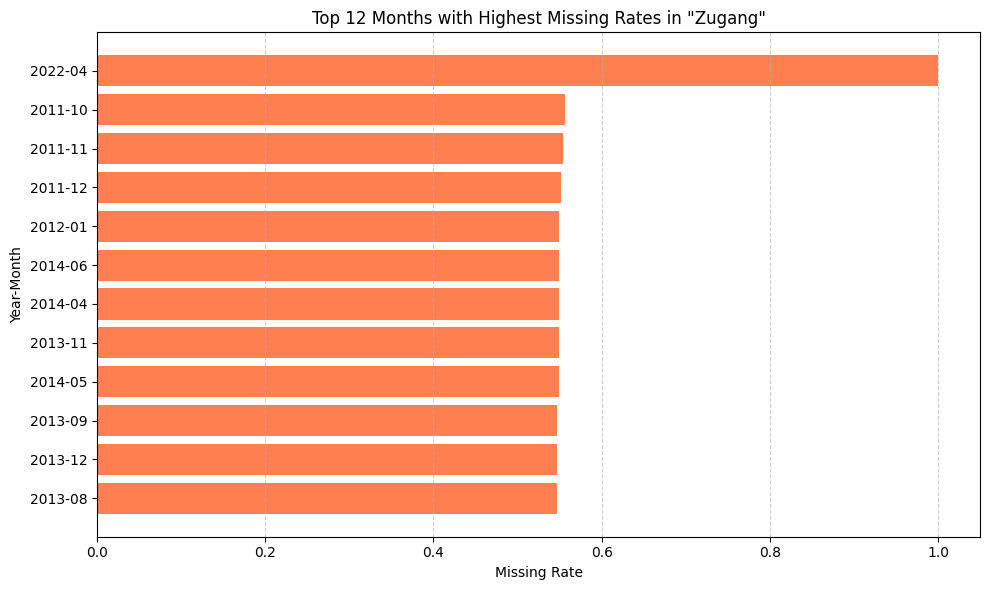

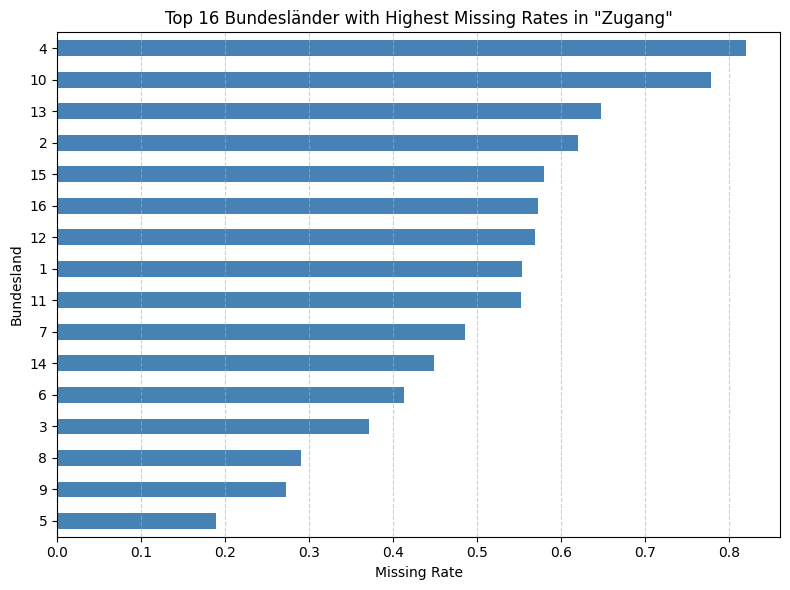

In [14]:
# Step 1: Calculate missing rate per Year-Month
month_missing = (
    df_complete.groupby(['Year', 'Month'])['Zugang']
    .apply(lambda x: x.isnull().mean())
    .reset_index(name='missing_rate')
)

# Step 2: Add a 'Year-Month' label column (for plotting)
month_missing['Year-Month'] = (
    month_missing['Year'].astype(str) + '-' + month_missing['Month'].astype(str).str.zfill(2)
)

# Step 3: Missing rate per Bundesland
bundesland_missing = (
    df_complete.groupby('Bundesland')['Zugang']
    .apply(lambda x: x.isnull().mean())
    .sort_values(ascending=False)
)

# Step 4: Print summary
print("\nMonths with highest missing rates:")
print(month_missing.sort_values('missing_rate', ascending=False).head(12))

print("\nBundesländer with highest missing rates:")
print(bundesland_missing.head(10))

# Step 5: Visualize top 12 months with highest missing rates
import matplotlib.pyplot as plt

top_months = month_missing.sort_values('missing_rate', ascending=False).head(12)

plt.figure(figsize=(10, 6))
plt.barh(top_months['Year-Month'], top_months['missing_rate'], color='coral')
plt.xlabel('Missing Rate')
plt.ylabel('Year-Month')
plt.title('Top 12 Months with Highest Missing Rates in "Zugang"')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step 6: Visualize top 16 Bundesländer with highest missing rates
top_bundeslaender = bundesland_missing.head(16)

plt.figure(figsize=(8, 6))
top_bundeslaender.plot(kind='barh', color='steelblue')
plt.xlabel('Missing Rate')
plt.ylabel('Bundesland')
plt.title('Top 16 Bundesländer with Highest Missing Rates in "Zugang"')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





Plot the time series for Berufsgruppe Altenpflege (812) for the variable Zugang.

In [ ]:
 # Subset Altenpflege and plot Zugang
import matplotlib.pyplot as plt

# Filter pflege
pflege = df_complete[df_complete['BKZ'] == 821]

# Group by Bundesland
Pflege_grouped = pflege.groupby('Bundesland')

# Plot
plt.figure(figsize=(12, 6))
for name, group in Pflege_grouped:
    plt.plot(group.index, group['Zugang'], marker='o', label=name)

plt.title('Pflege Zugang by Bundesland Over Time')
plt.xlabel('Date')
plt.ylabel('Pflege Zugang')
plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



Plot the time series graphs for Zugang for all Berufsgruppen. 

In [ ]:
# Time series graphs by Berufsgruppen for Zugang 

import matplotlib.pyplot as plt


# Group by BKZ and then by Bundesland
bkz_groups = df_complete.groupby('Beruf')

for Beruf, group in bkz_groups:
    plt.figure(figsize=(12, 6))
    
    # Group within BKZ by Bundesland
    for bundesland, bl_group in group.groupby('Bundesland'):
        plt.plot(bl_group.index, bl_group['Zugang'], marker='o', label=bundesland)
    
    plt.title(f'Berufsgruppe {Beruf}')
    plt.xlabel('Date')
    plt.ylabel('Zugang')
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plot the time series graphs for Bestand for all Berufsgruppen. 

In [ ]:
# Time series graphs by Berufsgruppen for Bestand

import matplotlib.pyplot as plt

# Group by BKZ and then by Bundesland
bkz_groups = df_complete.groupby('Beruf')

for Beruf, group in bkz_groups:
    plt.figure(figsize=(12, 6))
    
    # Group within BKZ by Bundesland
    for bundesland, bl_group in group.groupby('Bundesland'):
        plt.plot(bl_group.index, bl_group['Bestand'], marker='o', label=bundesland)
    
    plt.title(f'Berufsgruppe {Beruf}')
    plt.xlabel('Date')
    plt.ylabel('Bestand')
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plot the time series graphs for Vakanzzeit for all Berufsgruppen. 

In [ ]:
# Time series graphs by Berufsgruppen for Vakanzzeit

import matplotlib.pyplot as plt


# Group by BKZ and then by Bundesland
bkz_groups = df_complete.groupby('Beruf')

for Beruf, group in bkz_groups:
    plt.figure(figsize=(12, 6))
    
    # Group within BKZ by Bundesland
    for bundesland, bl_group in group.groupby('Bundesland'):
        plt.plot(bl_group.index, bl_group['abgesch_Vakanzzeit_Tage'], marker='o', label=bundesland)
    
    plt.title(f'Berufsgruppe {Beruf}')
    plt.xlabel('Date')
    plt.ylabel('abgesch_Vakanzzeit_Tage')
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plot the time series graphs for Relation for all Berufsgruppen. 

In [ ]:
# Time series graphs by Berufsgruppen for Relation

import matplotlib.pyplot as plt

# Group by BKZ and then by Bundesland
bkz_groups = df_complete.groupby('Beruf')

for Beruf, group in bkz_groups:
    plt.figure(figsize=(12, 6))
    
    # Group within BKZ by Bundesland
    for bundesland, bl_group in group.groupby('Bundesland'):
        plt.plot(bl_group.index, bl_group['Relation'], marker='o', label=bundesland)
    
    plt.title(f'Berufsgruppe {Beruf}')
    plt.xlabel('Date')
    plt.ylabel('Relation')
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plotting time series graphs by Berufsgruppe for Zugang between Nov 2016 and Jan 2017 to inquire drop/discontinuity. 

In [ ]:
import matplotlib.pyplot as plt

#  Now this will work
df_filtered = df_complete.loc['2016-11-01':'2017-01-01']

# Group by Beruf
bkz_groups_filtered = df_filtered.groupby('Beruf')

for beruf, group in bkz_groups_filtered:
    plt.figure(figsize=(12, 6))
    
    # Group by Bundesland within each Beruf
    for bundesland, bl_group in group.groupby('Bundesland'):
        plt.plot(bl_group.index, bl_group['Zugang'], marker='o', label=bundesland)
    
    plt.title(f'Zugang: {beruf} (2016-2017)')
    plt.xlabel('Date')
    plt.ylabel('Zugang')
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_filtered.head

Plotting time series graphs by Berufsgruppe for Zugang between May 2012 and August 2012 to inquire drop/discontinuity. 

In [ ]:
# Time series graphs by Berufsgruppen for Zugang in restricted time period to inquire discontinuity

import matplotlib.pyplot as plt

#  Now this will work
df_filtered_2 = df_complete.loc['2012-05-01':'2012-08-01']

# Group by Beruf
bkz_groups_filtered_2 = df_filtered_2.groupby('Beruf')

for beruf, group in bkz_groups_filtered_2:
    plt.figure(figsize=(12, 6))
    
    # Group by Bundesland within each Beruf
    for bundesland, bl_group in group.groupby('Bundesland'):
        plt.plot(bl_group.index, bl_group['Zugang'], marker='o', label=bundesland)
    
    plt.title(f'Zugang: {beruf} (2016–2018)')
    plt.xlabel('Date')
    plt.ylabel('Bestand')
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_filtered_2.head


Correlation analysis of Berufsgruppen

In [ ]:

# Correlation of Berufsgruppen

# Step 1: Create the Beruf-profiles based on mean of numeric variables
beruf_profiles = df_complete.groupby('Beruf').mean(numeric_only=True)

# Step 2: Compute the covariance matrix across Berufe
cor_between_berufe = beruf_profiles.T.corr()

cor_between_berufe

In [ ]:
# Heatmap of correlation between jobs

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
sns.heatmap(cor_between_berufe, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Berufe Based on Mean Profiles')
plt.tight_layout()
plt.show()


In [ ]:
# Corr Matrix

import pandas as pd

corr_matrix = df_complete.corr(numeric_only=True)
corr_matrix



Plot Bundesländer sorted by mean of all numeric variables:

In [ ]:
grouped_means_Bundesland = df_complete.groupby('Bundesland').mean(numeric_only=True)

# Sort each column in descending order (highest mean at top)
ranked_Bundesland = grouped_means_Bundesland.sort_values(by=grouped_means_Bundesland.columns.tolist(), ascending=False)
print(ranked_Bundesland)


import matplotlib.pyplot as plt

# One plot per column
for col in grouped_means_Bundesland.columns:
    grouped_means_Bundesland[col].sort_values(ascending=False).plot(kind='barh', figsize=(8, 20))
    plt.title(f'Mean {col} by Bundesland')
    plt.xlabel(col)
    plt.ylabel('Bundesland')
    plt.gca().invert_yaxis()  # Highest at top
    plt.tight_layout()
    plt.show()

In [ ]:
df_complete.to_csv(r"C:\Users\jhummels\OneDrive - DIW Berlin\GEHLEN~1\Data\BA_data\A_GEME~1\Merged_data_cleaned.csv", index=False)